In [1]:
import sqlite3

import polars as pl
import polars.selectors as cs

## Setup

I've decided that for this year I want to commit to using [Polars](https://pola.rs/) in a Jupyter notebook for all the puzzles.
So here I load the SQLite data into a Polars DataFrame that I'll try to reuse across all puzzles.

I cheat a _little_ bit here by starting with a query that I incrementally worked toward [in 2022](https://dev.to/ajkerrigan/series/21177).

In [2]:
con = sqlite3.connect("5784/noahs.sqlite")
df = pl.read_database(
    connection=con,
    query="""
        select
          c.*,
          o.orderid,
          o.ordered,
          o.shipped,
          o.total,
          i.qty,
          i.unit_price,
          p.sku,
          p.desc,
          p.wholesale_cost
        from
          customers c
          join orders o on c.customerid = o.customerid
          join orders_items i on o.orderid = i.orderid
          join products p on i.sku = p.sku
  """,
)

## Puzzle Solutions

### Day 1

**Useful Facts:**

- Target customer is a private investigator
- Translating that customer's last name to numbers using a phone pad as a key produces the customer's phone number

#### Polars Helper

It would be nice to have a convenient Polars-native way to translate a customer's name to its phone number equivalent.
This seems like a good case for [extending the Polars expression namespace](https://pola-rs.github.io/polars/py-polars/html/reference/api.html#extending-the-api).

In [3]:
@pl.api.register_expr_namespace("phonepad")
class Phonepad:
    def __init__(self, expr: pl.Expr):
        self._expr = expr

    def to_numbers(self):
        return (
            self._expr.str.to_lowercase()
            .str.replace_all(r"[^a-z]", "")
            .str.replace_all(r"[abc]", "2")
            .str.replace_all(r"[def]", "3")
            .str.replace_all(r"[ghi]", "4")
            .str.replace_all(r"[jkl]", "5")
            .str.replace_all(r"[mno]", "6")
            .str.replace_all(r"[pqrs]", "7")
            .str.replace_all(r"[tuv]", "8")
            .str.replace_all(r"[wxyz]", "9")
        )

#### Solution

With a convenience expression namespace/method, we can check to see if a customer's phonified name contains the digits of their phone number.

In [4]:
%time
day1 = df.filter(
    pl.col("name")
    .phonepad.to_numbers()
    .str.contains(pl.col("phone").str.replace_all(r"[^\d]+", ""))
)

%time
day1.select("phone").unique().item()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs
CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.29 µs


'826-636-2286'

#### Lazy Alternative

It seems useful to practice using the Polars [LazyFrame API](https://pola-rs.github.io/polars/user-guide/lazy/using/). There's no
`scan_database()` method that I can see, and since we're reusing a single DataFrame across multiple days it seems sensible
to have the whole thing in memory anyway.

_But_... we can call `.lazy()` on it and see what optimizations we get under the covers. In this case the time difference
seems negligible, but it's interesting in any case. Note that the unoptimized [query plan](https://pola-rs.github.io/polars/user-guide/lazy/query-plan/)
has two steps:

1. Select all columns from every row
2. Apply a filter

Where the optimized plan merges those operations into a single step, filtering as part of the selection. Neat!

_I still suspect there's a smarter way to do that janky multi-replacement though..._

Unoptimized query plan & graph...
FILTER col("name").str.lowercase().str.replace([Utf8([^a-z]), Utf8()]).str.replace([Utf8([abc]), Utf8(2)]).str.replace([Utf8([def]), Utf8(3)]).str.replace([Utf8([ghi]), Utf8(4)]).str.replace([Utf8([jkl]), Utf8(5)]).str.replace([Utf8([mno]), Utf8(6)]).str.replace([Utf8([pqrs]), Utf8(7)]).str.replace([Utf8([tuv]), Utf8(8)]).str.replace([Utf8([wxyz]), Utf8(9)]).str.contains([col("phone").str.replace([Utf8([^\d]+), Utf8()])]) FROM
DF ["customerid", "name", "address", "citystatezip"]
 PROJECT */18 COLUMNS
 SELECTION: "None"


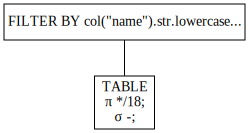


Optimized query plan...
DF ["customerid", "name", "address", "citystatezip"]
 PROJECT */18 COLUMNS
 SELECTION: "col(\"name\").str.lowercase().str.replace([Utf8([^a-z]), Utf8()]).str.replace([Utf8([abc]), Utf8(2)]).str.replace([Utf8([def]), Utf8(3)]).str.replace([Utf8([ghi]), Utf8(4)]).str.replace([Utf8([jkl]), Utf8(5)]).str.replace([Utf8([mno]), Utf8(6)]).str.replace([Utf8([pqrs]), Utf8(7)]).str.replace([Utf8([tuv]), Utf8(8)]).str.replace([Utf8([wxyz]), Utf8(9)]).str.contains([col(\"phone\").str.replace([Utf8([^\\d]+), Utf8()])])"


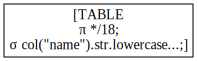

'826-636-2286'

In [15]:
day1_lazy = df.lazy().filter(
    pl.col("name")
    .phonepad.to_numbers()
    .str.contains(pl.col("phone").str.replace_all(r"[^\d]+", ""))
)

print("Unoptimized query plan & graph...")
print("\n".join(day1_lazy.explain(optimized=False).split(";")))
day1_lazy.show_graph(optimized=False)

print("\nOptimized query plan...")
print("\n".join(day1_lazy.explain(optimized=True).split(";")))
day1_lazy.show_graph(optimized=True)

day1_lazy.collect().select("phone").unique().item()

### Day 2

**Useful Facts:**

- Target customer had initials JP
- Bought coffee and bagels in 2017

This is doable by chaining together filters against a customer's name, order history and order date.

In [7]:
day2 = df.filter(
    (pl.col("name").str.contains(r"J.*P"))
    & (pl.col("desc").str.contains(r"(?i)(coffee|bagel)"))
    & (pl.col("ordered").str.strptime(pl.Datetime).dt.year() == 2017)
)

day2.select("phone").unique().item()

'332-274-4185'

### Day 3

**Useful Facts:**

- Target customer lives in last customer's neighborhood
  - Maybe city, maybe zip code
  - Try city/state/zip match first
- Cancer
  - June 21 - July 22
  - Julian values 173 - 203
- Year of the rabbit
  - Birth year mod 12 = 7

In [8]:
neighborhood = day2.select("citystatezip").unique().item()

day3 = df.filter(
    (
        pl.col("birthdate")
        .str.strptime(pl.Datetime)
        .dt.ordinal_day()
        .is_between(173, 203)
    )
    & (pl.col("birthdate").str.strptime(pl.Datetime).dt.year() % 12 == 7)
    & (pl.col("citystatezip") == neighborhood)
)

day3.select(["name", "citystatezip", "phone"]).unique()

name,citystatezip,phone
str,str,str
"""Robert Morton""","""Jamaica, NY 11…","""917-288-9635"""


### Day 4

**Useful Facts:**

- Target customer buys pastries early - before 5am
  - Years ago
- Is a woman
- Came by bike - maybe assume close by, same city?

In [14]:
day4 = (
    df.filter(
        (pl.col("sku").str.starts_with("BKY"))
        & (pl.col("ordered").str.strptime(pl.Datetime).dt.hour() == 4)
    )
    .group_by(["name", "phone"])
    .agg(pl.col("orderid").count().alias("ordercount"))
    .top_k(5, by="ordercount")
)

day4.select(["name", "phone", "ordercount"])

name,phone,ordercount
str,str,u32
"""Renee Harmon""","""607-231-3605""",5
"""James Eaton""","""838-958-4372""",3
"""Lindsey Mays""","""631-280-4337""",2
"""Christopher Ga…","""716-263-0817""",2
"""Glenn Wolfe""","""716-622-1529""",1


#### Lazy Alternative

There's a bit more going on here than on day 1, so I'm curious what a LazyFrame's query plan optimizations would look like here.

Again it's worth pointing out that lazy evaluation doesn't seem particularly useful for these challenges, given the size and reusability
of the dataset. It's still neat to see the sorts of plan optimizations Polars does under the covers though.

Unoptimized query plan & graph...
SLICE[offset: 0, len: 5]
  SORT BY [col("ordercount")]
    AGGREGATE
    	[col("orderid").count().alias("ordercount")] BY [col("name"), col("phone")] FROM
      FILTER [(col("sku").str.starts_with([Utf8(BKY)])) & ([(col("ordered").str.strptime([Utf8(raise)]).dt.hour()) == (4)])] FROM

      DF ["customerid", "name", "address", "citystatezip"]
 PROJECT */18 COLUMNS
 SELECTION: "None"


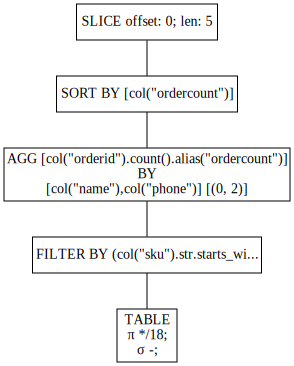

Optimized query plan & graph...
SORT BY [col("ordercount")]
  AGGREGATE
  	[col("orderid").count().alias("ordercount")] BY [col("name"), col("phone")] FROM
    DF ["customerid", "name", "address", "citystatezip"]
 PROJECT 5/18 COLUMNS
 SELECTION: "[(col(\"sku\").str.starts_with([Utf8(BKY)])) & ([(col(\"ordered\").str.strptime([Utf8(raise)]).dt.hour()) == (4)])]"


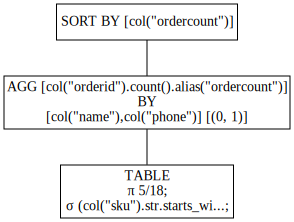

name,phone,ordercount
str,str,u32
"""Renee Harmon""","""607-231-3605""",5
"""James Eaton""","""838-958-4372""",3
"""Lindsey Mays""","""631-280-4337""",2
"""Christopher Ga…","""716-263-0817""",2
"""Mark Huber""","""516-870-0290""",1


In [16]:
day4_lazy = (
    df.lazy()
    .filter(
        (pl.col("sku").str.starts_with("BKY"))
        & (pl.col("ordered").str.strptime(pl.Datetime).dt.hour() == 4)
    )
    .group_by(["name", "phone"])
    .agg(pl.col("orderid").count().alias("ordercount"))
    .top_k(5, by="ordercount")
)

print("Unoptimized query plan & graph...")
print("\n".join(day4_lazy.explain(optimized=False).split(";")))
day4_lazy.show_graph(optimized=False)

print("Optimized query plan & graph...")
print("\n".join(day4_lazy.explain(optimized=True).split(";")))
day4_lazy.show_graph(optimized=True)

day4_lazy.collect().select(["name", "phone", "ordercount"])

### Day 5

- Target customer is from Staten Island
- Has lots of (old) cats

In [11]:
day5 = (
    df.filter(
        (pl.col("citystatezip").str.starts_with("Staten Island"))
        & (pl.col("desc").str.contains(r"(?i)senior.*cat"))
    )
    .group_by(["name", "phone"])
    .agg(pl.col("orderid").count().alias("ordercount"))
)

day5.top_k(5, by="ordercount")

name,phone,ordercount
str,str,u32
"""Nicole Wilson""","""631-507-6048""",21
"""Dawn Shelton""","""680-260-3507""",6
"""Kayla Solis""","""929-877-1866""",6
"""Brian Hudson I…","""516-570-4577""",6
"""Sean Wade Jr.""","""347-916-9069""",5


### Day 6

- Target customer is a bargain hunter
- Noah's loses money on this customer's purchases

In [12]:
day6 = (
    df.with_columns(
        profit=pl.col("qty") * (pl.col("unit_price") - pl.col("wholesale_cost"))
    )
    .group_by(["name", "phone"])
    .agg(pl.col("profit").sum())
)

day6.bottom_k(5, by="profit")

name,phone,profit
str,str,f64
"""Sherri Long""","""585-838-9161""",-92.03
"""Lisa Archer""","""989-571-6656""",-2.28
"""Chelsea Fergus…","""716-633-6717""",-0.17
"""David Pratt""","""718-810-9458""",-0.04
"""Sharon Washing…","""716-953-2607""",-0.02
